# Q4 Permutation Tests

In [1]:
import shap
from sklearn.model_selection import train_test_split
X,y = shap.datasets.adult() # Numerical version of data
X_display, y_display = shap.datasets.adult(display=True) # Human-readable data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train.dtypes

/Users/zhao/opt/anaconda3/envs/xai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Age               float32
Workclass            int8
Education-Num     float32
Marital Status       int8
Occupation           int8
Relationship        int64
Race                 int8
Sex                  int8
Capital Gain      float32
Capital Loss      float32
Hours per week    float32
Country              int8
dtype: object

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, random_state=10)
clf.fit(X_train.values, y_train)

GradientBoostingClassifier(random_state=10)

(a) Report the zero-one classification error (using a classification threshold of 0.5) and log-loss for both the train and test sets.

In [3]:
from sklearn.metrics import log_loss

# Predict probabilities for train and test sets
train_pred = clf.predict_proba(X_train.values)[:, 1]
test_pred = clf.predict_proba(X_test.values)[:, 1]

# Convert probabilities to binary predictions using a threshold of 0.5
train_pred_binary = (train_pred >= 0.5).astype(int)
test_pred_binary = (test_pred >= 0.5).astype(int)

# Calculate zero-one classification error
train_error = (train_pred_binary != y_train).mean()
test_error = (test_pred_binary != y_test).mean()

# Calculate log-loss
train_loss = log_loss(y_train, train_pred)
test_loss = log_loss(y_test, test_pred)

train_error, train_loss, test_error, test_loss

(0.1314880221130221,
 0.2877588985367273,
 0.13373253493013973,
 0.2940315282808109)

(b) Implement the permutation test approach for the trained model. For each feature, measure the change in the test set zero-one error after permuting the corresponding feature column. Visualize the importance values with a bar plot.

In [4]:
import numpy as np

def perm_test(clf, X_test, y_test):
    # Calculate the original zero-one error
    original_error = test_error

    # Initialize an array to store the error changes
    error_changes = np.zeros(X_test.shape[1])

    # Permute each feature column and calculate the error change
    for i in range(X_test.shape[1]):
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, i])
        y_pred_permuted = clf.predict(X_permuted)
        error_changes[i] = ((y_pred_permuted >= 0.5).astype(int) != y_test).mean() - original_error

    return error_changes

# Perform permutation test
error_changes = perm_test(clf, X_test.values, y_test)

# Print the error changes for each feature
# for feature, error_change in zip(X_test.columns, error_changes):
#     print(f'{feature}: {error_change}')



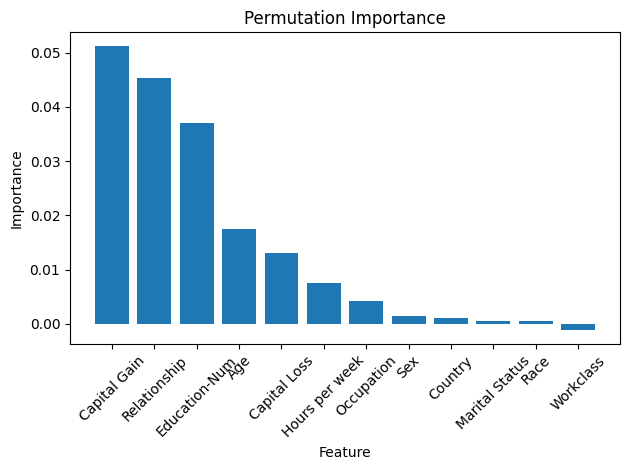

In [5]:
import matplotlib.pyplot as plt

# Get feature names
feature_names = X_test.columns

# Sort feature importances in descending order
sorted_indices = error_changes.argsort()[::-1]
sorted_importances = error_changes[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Visualize importance values with a bar plot
# plt.figure(figsize=(7, 7))
plt.bar(sorted_feature_names, sorted_importances)
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Permutation Importance')
plt.tight_layout()
plt.savefig('q4_b.png')

(c) Permutation tests are inherently stochastic because they permute features randomly. Run the permutation test from part (b) 10 times and visualize the variance in the importance values using a bar plot with standard deviation error bars.

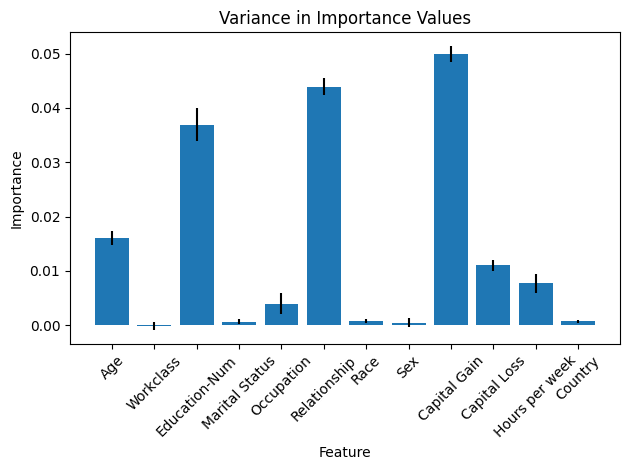

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Run permutation test 10 times and collect importance values
importance_values = []
for _ in range(10):
    error_changes = perm_test(clf, X_test.values, y_test)
    importance_values.append(error_changes)

# Calculate mean and standard deviation of importance values
mean_importance = np.mean(importance_values, axis=0)
std_importance = np.std(importance_values, axis=0)

# Plot the importance values with error bars
plt.bar(feature_names, mean_importance, yerr=std_importance)
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Variance in Importance Values')
plt.tight_layout()
plt.savefig('q4_c.png')

(d) One possible variation of the permutation test is to change the feature removal approach. Implement a new method similar to (b) that removes features by setting them to their mean instead of permuting them. Visualize the importance values using a bar plot.

Age: 0.007369875633348677
Workclass: -0.0001535390756947641
Education-Num: 0.017964071856287428
Marital Status: 0.0006141563027790564
Occupation: 0.00936588361738061
Relationship: 0.048978965146629805
Race: 0.0006141563027790564
Sex: 0.0
Capital Gain: 0.030861354214647613
Capital Loss: 0.007369875633348677
Hours per week: 0.003070781513895282
Country: 0.0007676953784738205


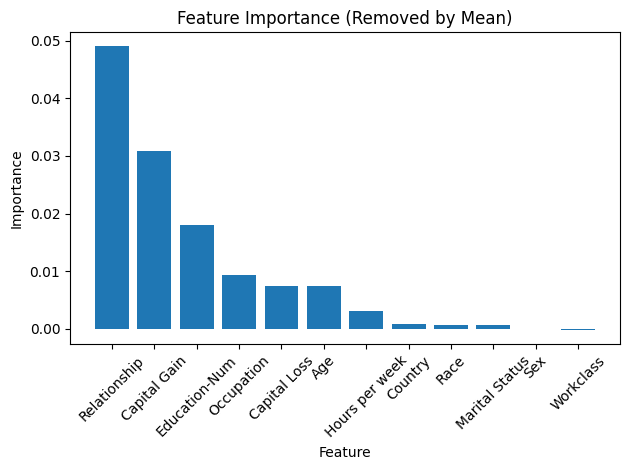

In [7]:
def remove_by_mean(clf, X, y):
    # Fit the model on the original data
    original_error = test_error
    
    # Initialize an array to store the error changes
    error_changes = np.zeros(X.shape[1])
    
    # Perform feature removal by setting features to their mean
    for i in range(X.shape[1]):
        # Create a copy of the feature matrix
        X_removed = X.copy()
        X_removed[:, i] = np.mean(X_removed[:, i])
    
        # Fit the model on the permuted data
        y_pred_removed = clf.predict(X_removed)
        
        error_changes[i] = ((y_pred_removed >= 0.5).astype(int) != y).mean() - original_error
    
    return error_changes

# Perform permutation test
error_changes_removed = remove_by_mean(clf, X_test.values, y_test)

# Print the error changes for each feature
for feature, error_change in zip(X_test.columns, error_changes_removed):
    print(f'{feature}: {error_change}')
    
# Get feature names
feature_names = X_test.columns

# Sort feature importances in descending order
sorted_indices = error_changes_removed.argsort()[::-1]
sorted_importances = error_changes_removed[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Visualize importance values with a bar plot
plt.bar(sorted_feature_names, sorted_importances)
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance (Removed by Mean)')
plt.tight_layout()
plt.savefig('q4_d.png')


(e) Another possible variation is to change the model behavior we measure. Implement a new method similar to (b) that measures the change in the test set log-loss rather than the zero-one error. Visualize the importance values using a bar plot.

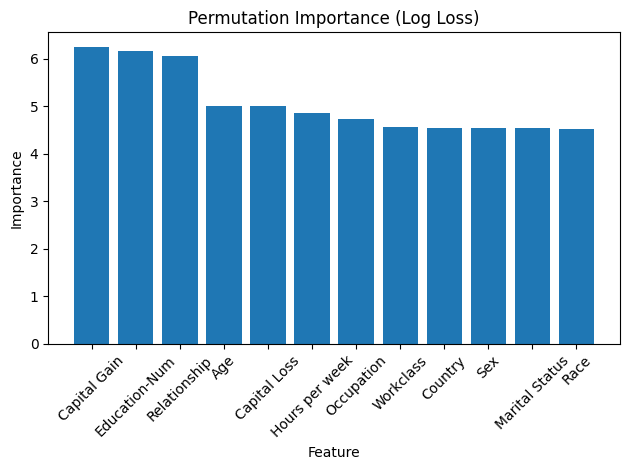

In [8]:
def perm_test_log_loss(clf, X_test, y_test):
    original_error = test_loss # test_loss = log_loss(y_test, test_pred)

    # Initialize an array to store the error changes
    error_changes = np.zeros(X_test.shape[1])

    # Permute each feature column and calculate the error change
    for i in range(X_test.shape[1]):
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, i])
        y_pred_permuted = clf.predict(X_permuted)
        error_changes[i] = log_loss(y_test, y_pred_permuted) - original_error

    return error_changes

# Perform permutation test
error_changes = perm_test_log_loss(clf, X_test.values, y_test)

# Get feature names
feature_names = X_test.columns

# Sort feature importances in descending order
sorted_indices = error_changes.argsort()[::-1]
sorted_importances = error_changes[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Visualize importance values with a bar plot
plt.bar(sorted_feature_names, sorted_importances)
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Permutation Importance (Log Loss)')
plt.tight_layout()
plt.savefig('q4_e.png')


# Q5 Popular Feature Importance Packages

(a) 
Note that both TreeSHAP and KernelSHAP require a set of baselines, which are used to replace held-out features with samples from their marginal distribution. For this problem, use the last 100 samples from the test set (X_test[-100:]) as the baselines.
Visualize the results for each method using three separate summary plots

In [4]:
import numpy as np

explicands = X_test[:200]
baselines = X_test[-100:]

### TreeSHAP

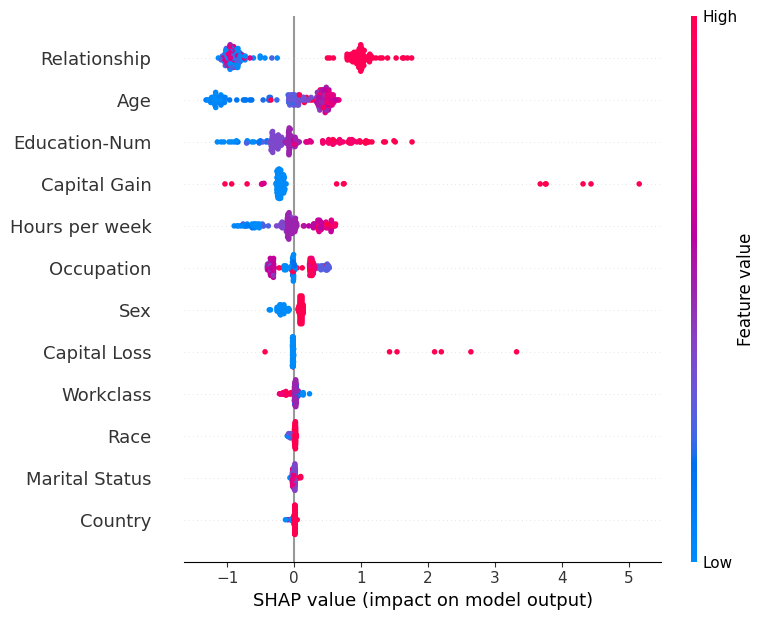

In [5]:
import shap
explainer_tree = shap.TreeExplainer(clf, baselines)
attributions_tree = explainer_tree.shap_values(explicands)
shap.summary_plot(attributions_tree, explicands)

In [85]:
attributions_tree.shape, explicands.shape

((200, 12), (200, 12))

In [119]:
type(attributions_tree)

numpy.ndarray

According to the summary plots, the most important feature for TreeSHAP is Capital Gain.

### KernelSHAP

In [6]:
explainer_kernel = shap.KernelExplainer(clf.predict_proba, baselines)
attributions_kernel = explainer_kernel.shap_values(explicands)[:,:,1]

100%|██████████| 200/200 [01:23<00:00,  2.38it/s]


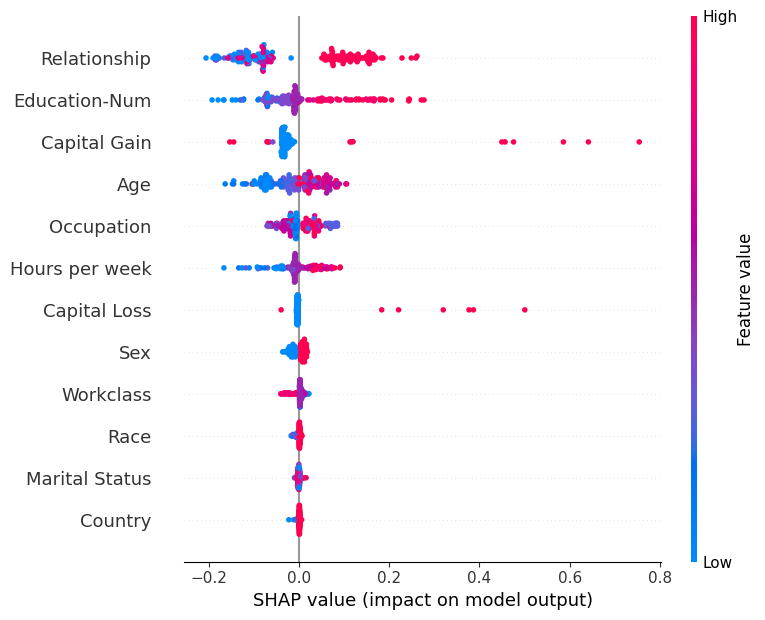

In [91]:
shap.summary_plot(attributions_kernel, explicands)

According to the summary plots, the most important feature for KernelSHAP is Capital Gain.

LIME

[1]


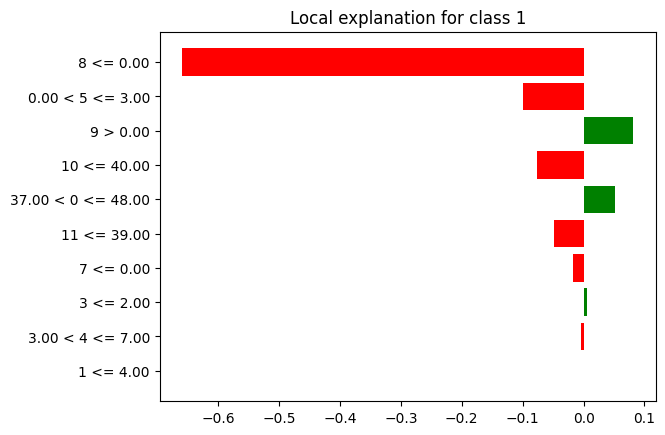

In [137]:
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt

explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values)

attributions_lime = []
for explicand in explicands.values:
    exp = explainer_lime.explain_instance(explicand, clf.predict_proba)
    exp.as_pyplot_figure()
    print(exp.available_labels())
    attribution = explainer_lime.explain_instance(explicand, clf.predict_proba).local_exp[1]
    # Note: you must reshape the attribution and run explain_instance for every explicand
    attributions_lime.append(attribution)
    break

# Convert list of attributions to numpy array
attributions_lime = np.array(attributions_lime)



In [129]:
shap.summary_plot(attributions_lime, explicands.values)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

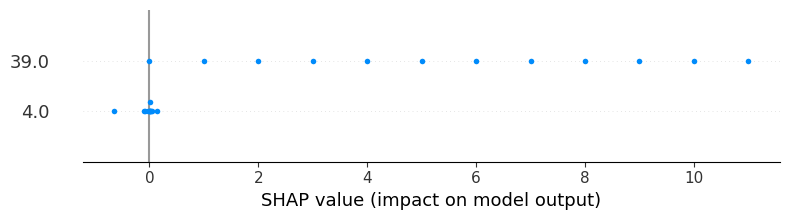

In [147]:
import shap
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['0', '1'], categorical_features=[1,3,4,5,6,7,11])
attribution = explainer.explain_instance(explicands.values[0], clf.predict_proba, num_features=12).local_exp[1]
# Note: you must reshape the attribution and run explain_instance for every explicand

shap.summary_plot(np.array(attribution), explicands.values[0])


In [93]:
attributions_lime.shape, explicands.shape

((200, 10, 2), (200, 12))

(b) Visualize the attributions from each method for the features “Age” and “Hours per week” with a scatter plot, putting the feature value on the x-axis and the feature attribution on the y-axis. Use the matplotlib library to generate the plots. Based on these plots, what observations can you make about how the these features relate to the model’s income prediction?

In [16]:
import matplotlib.pyplot as plt

explicands_age = explicands['Age']
explicands_hours_per_week = explicands['Hours per week']

TreeSHAP

In [9]:
attributions_tree.shape

(200, 12)

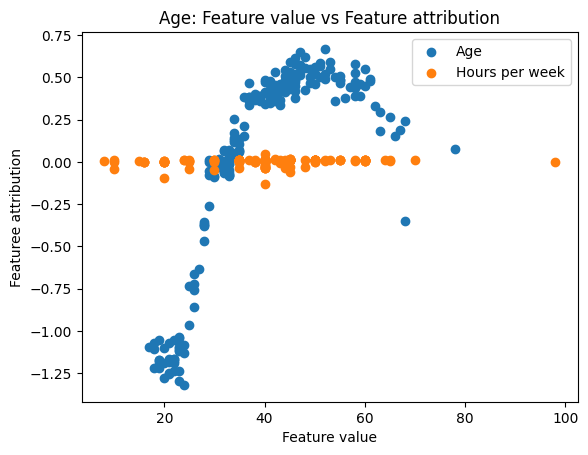

In [20]:
age_tree = attributions_tree[:, 0]
hours_per_week_tree = attributions_tree[:, 11]

plt.scatter(explicands_age, age_tree)
plt.scatter(explicands_hours_per_week, hours_per_week_tree)
plt.legend(['Age', 'Hours per week'])
plt.xlabel('Feature value')
plt.ylabel('Featuree attribution')
plt.title('TreeSHAP: Feature value vs Feature attribution')
plt.show()




KernelSHAP

In [10]:
attributions_kernel.shape

(200, 12)

In [ ]:
age_kernel = attributions_kernel[:, 0]
hours_per_week_kernel = attributions_kernel[:, 11]